In [116]:
import sys
import re
import numbers
import os
import pickle
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, List, Set, Dict, Iterable, Callable, Optional, Union

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

sns.set_style("darkgrid")

In [117]:
np.random.seed(0)

In [118]:
sys.path.insert(0, "../../")  # Добавляем родительскую директорию в `path`, чтобы python смог найти наши модули

In [119]:
# Проверим, что python теперь их видит:
from modules.preprocessing import MultilabelEncoder, RegexTransformer
from modules.base          import CustomTransformer
from modules.compose       import GroupByTransformer
from modules.outliers      import RangeOutlierDetector, DeltaFromMedianOutlierDetector, IQROutlierDetector
from modules.impute        import InterpolationImputer

<div class="alert alert-info">
  <h1><center>Data (2 балла)</center></h1></div>

In [120]:
df = pd.read_csv("data/train.csv", low_memory=False)
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(r'-', r'_', regex=True)
df.shape

(118936, 33)

In [121]:
pd.set_option("display.max_columns", df.shape[-1])
df.head()

,id,year,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_type,credit_score,co_applicant_credit_type,age,submission_of_application,ltv,region,security_type,status
0,89268,2019,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,216500,3.990,0.8696,1785.38,240.0,not_neg,not_int,not_lpsm,308000.0,sb,pr,home,1U,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct,0
1,125974,2019,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,606500,3.875,0.2662,3279.06,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct,0
2,62363,2019,cf,Female,nopre,type1,p1,l1,nopc,nob/c,156500,NaN,NaN,NaN,360.0,neg_amm,not_int,not_lpsm,158000.0,sb,pr,home,1U,4860.0,CRIF,801,EXP,35-44,to_inst,99.050633,North,direct,1
3,106793,2019,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,306500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,6000.0,EQUI,798,EXP,35-44,to_inst,NaN,south,direct,1
4,66272,2019,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,206500,4.375,0.2750,0.00,360.0,not_neg,not_int,not_lpsm,298000.0,sb,sr,home,1U,10500.0,CRIF,554,EXP,>74,not_inst,69.295302,North,direct,0


Базовая информация о датафрейме:

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118936 entries, 0 to 118935
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         118936 non-null  int64  
 1   year                       118936 non-null  int64  
 2   loan_limit                 116225 non-null  object 
 3   gender                     118936 non-null  object 
 4   approv_in_adv              118209 non-null  object 
 5   loan_type                  118936 non-null  object 
 6   loan_purpose               118836 non-null  object 
 7   credit_worthiness          118936 non-null  object 
 8   open_credit                118936 non-null  object 
 9   business_or_commercial     118936 non-null  object 
 10  loan_amount                118936 non-null  int64  
 11  rate_of_interest           89781 non-null   float64
 12  interest_rate_spread       89625 non-null   float64
 13  upfront_charges            87

Разделим датасет на Х и у:

In [123]:
X = df.drop(columns=["status"])
y = df["status"]

Распределение целевой переменной по классам:

In [124]:
y.value_counts() / len(y)

0    0.753557
1    0.246443
Name: status, dtype: float64

### Train | Test split

Разбейте датасет на тренировочный и тестовый (оставьте 20% для теста, не забудтье зафиксировать random_seed)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Разделить конечно разделим... Но для анализа пока будем работать со всеми данными (Х в данном случае). Потом обучим окончательный вариант на тренировочной выборке и применим к обоим частям.

### First look and general info

Отобразите базовую информацию о датасете: размер, тип данных, базовые статистики

Выведем по каждой колонке данных датафрейма статистику (тип данных, процент пропусков, наличие/отсутсвие повторяющихся значений, уникальные категориальные значения).

In [126]:
with open('info/info_base.txt', 'w') as f:
    for col_name, col_values in X.items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

### Data types normalization

Проверьте, все ли признаки имеют правильный тип данных?

Описание данных с сайта:

Функции
- ID = идентификатор клиента заявителя
- year = год подачи заявки
- loan_limit = максимально доступная сумма кредита, которую можно взять
- Gender = тип пола
- approv_in_adv = Кредит предварительно одобрен или нет
- loan_type = Тип кредита
- loan_purpose = причина, по которой вы хотите занять деньги
- Credit_Worthiness = то, как кредитор определяет, что вы не выполните свои долговые обязательства, или насколько вы достойны получить новый кредит.
- open_credit = предварительно одобренный кредит между кредитором и заемщиком. Это позволяет заемщику делать повторные снятия до определенного предела.
- business_or_commercial = Тип использования суммы кредита
- loan_amount = Точная сумма кредита
- rate_of_interest = сумма, которую кредитор взимает с заемщика, и процент от основной суммы долга.
- Interest_rate_spread = разница между процентной ставкой, которую финансовое учреждение платит вкладчикам, и процентной ставкой, которую оно получает по кредитам.
- Upfront_charges = Комиссия, уплачиваемая кредитору заемщиком в качестве вознаграждения за выдачу нового кредита
- term = период погашения кредита
- Neg_ammortization = относится к ситуации, когда заемщик кредита вносит платеж меньше стандартного платежа, установленного банком.
- interest_only = сумма процентов
- lump_sum_payment = сумма денег, которая выплачивается одним платежом, а не в рассрочку.
- property_value = текущая стоимость будущих выгод, связанных с владением недвижимостью
- Construction_type = Тип вспомогательной конструкции
- occupancy_type = классификации относятся к категоризации структур на основе их использования
- Secured_by = Тип залога
- total_units = количество единиц
- income = относится к сумме денег, имущества и других денежных переводов, полученных в течение установленного периода времени.
- credit_type = тип кредита
- co-applicant_credit_type = дополнительное лицо, участвующее в процессе подачи заявки на кредит. И заявитель, и созаявитель подают и подписывают заявку на получение кредита.
- age = возраст заявителя
- submit_of_application = Убедитесь, что заявка заполнена или нет
- LTV = жизненная ценность (LTV) — это прогноз чистой прибыли.
- Region = место заявителя
- Security_Type = Тип залога
- status = статус займа (одобрен/отклонен)

Неверный тип данных имеет колонка credit_score. Поработаем с ней.

In [127]:
unique_values = df['credit_score'].unique()
numeric_values = pd.to_numeric(unique_values, errors='coerce')
numeric_values = numeric_values[~pd.isna(numeric_values)]
numeric_values.min(), numeric_values.max()

(500.0, 900.0)

При этом нечисловые значения имеют вид:

In [128]:
non_numeric_values = list(filter(lambda x: not (x.isnumeric()), unique_values))
non_numeric_values

['6_32',
 '_576',
 '_566',
 '_764',
 '640_',
 '71_2',
 '_801',
 '626_',
 '75_8',
 '_675']

Сделаем вывод, что знак нижнего подчёркивания можно просто убрать.

In [129]:
def clean_and_convert(value):
    clean_value = re.sub(r'[^\d-]+', '', value)
    return int(clean_value)

In [130]:
X['credit_score'] = X['credit_score'].apply(clean_and_convert)

Колонки id, year просто дропнем. Они не нужны.

In [131]:
X.drop(['id', 'year'], axis=1, inplace=True)

### Extreme values detection

Проверьте, есть ли аномальные данные? Постройте базовые визуализации там, где это уместно

In [132]:
def describe_numeric(X: pd.DataFrame, features: Union[str, Iterable[str], None] = None):
    
    if isinstance(features, str):
        X = X.loc[:, [features]]
    elif isinstance(features, Iterable):
        X = X.loc[:, features]

    for col_name, col_values in X.items():
        print(f"< {col_name} >".center(117, "-"))

        _, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(11.5, 12))

        _ = ax0.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        _ = ax1.boxplot(col_values.dropna(), labels=[""], vert=False, widths=0.8, showmeans=True)
        _ = ax2.hist(col_values.dropna())
        _ = ax3.hist(col_values.dropna())

        ax0.set(title=f"boxplot of {col_name}")
        ax1.set(title=f"boxplot of {col_name}, log axes", xscale="log")
        ax2.set(title=f"histogram of {col_name}")
        ax3.set(title=f"histogram of {col_name}, log axes", yscale="log", xscale="log")

        plt.show()

---------------------------------------------------< loan_amount >---------------------------------------------------


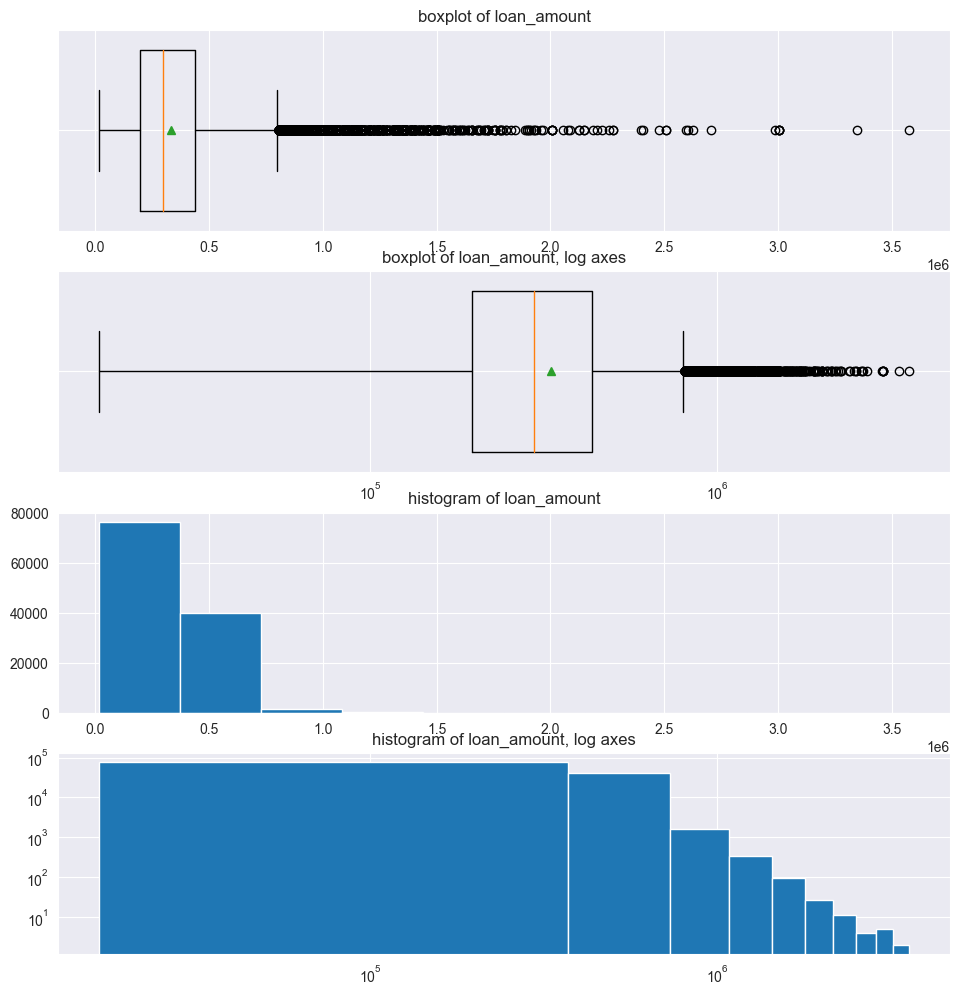

-------------------------------------------------< rate_of_interest >------------------------------------------------


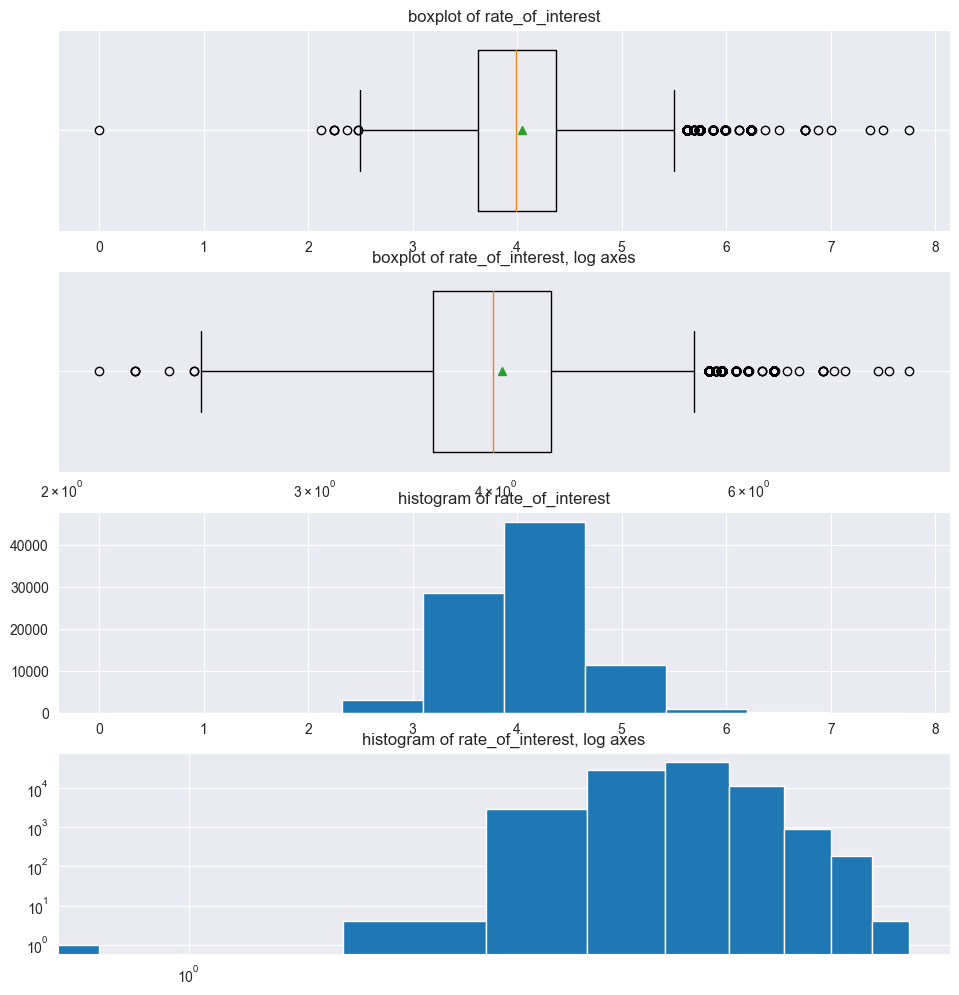

-----------------------------------------------< interest_rate_spread >----------------------------------------------


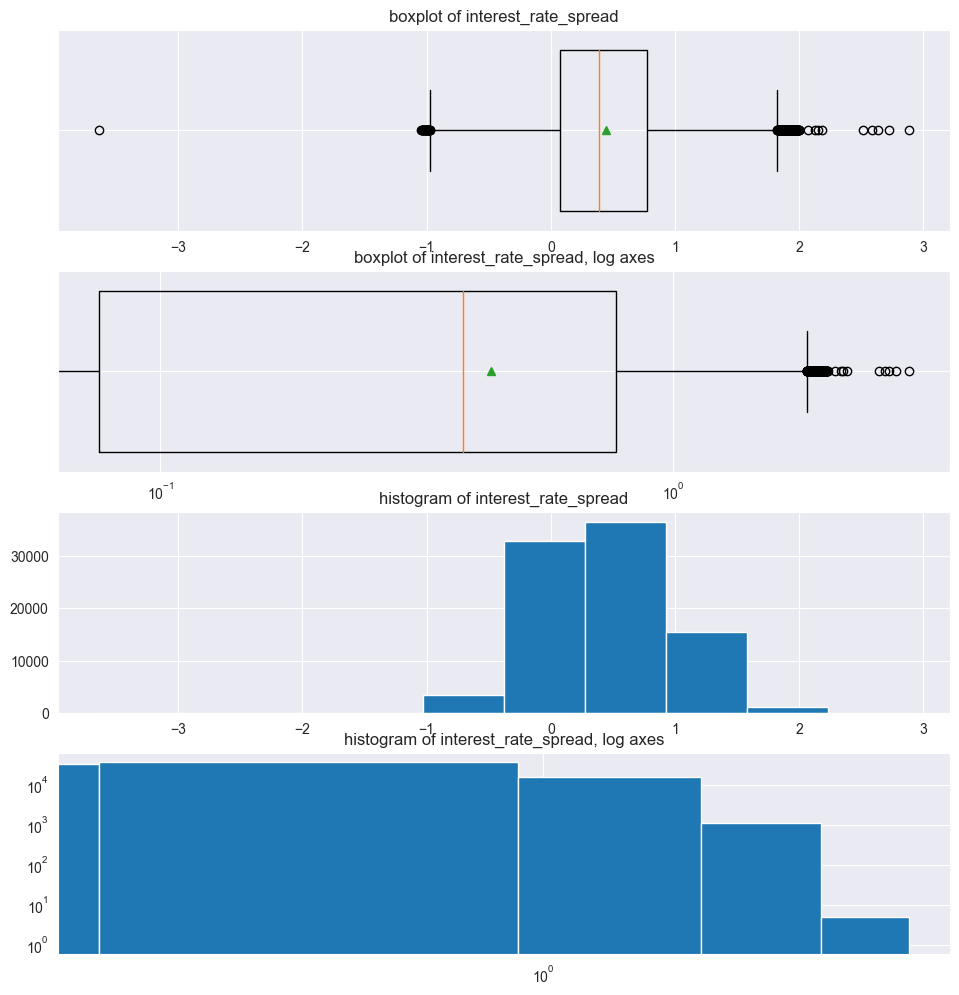

-------------------------------------------------< upfront_charges >-------------------------------------------------


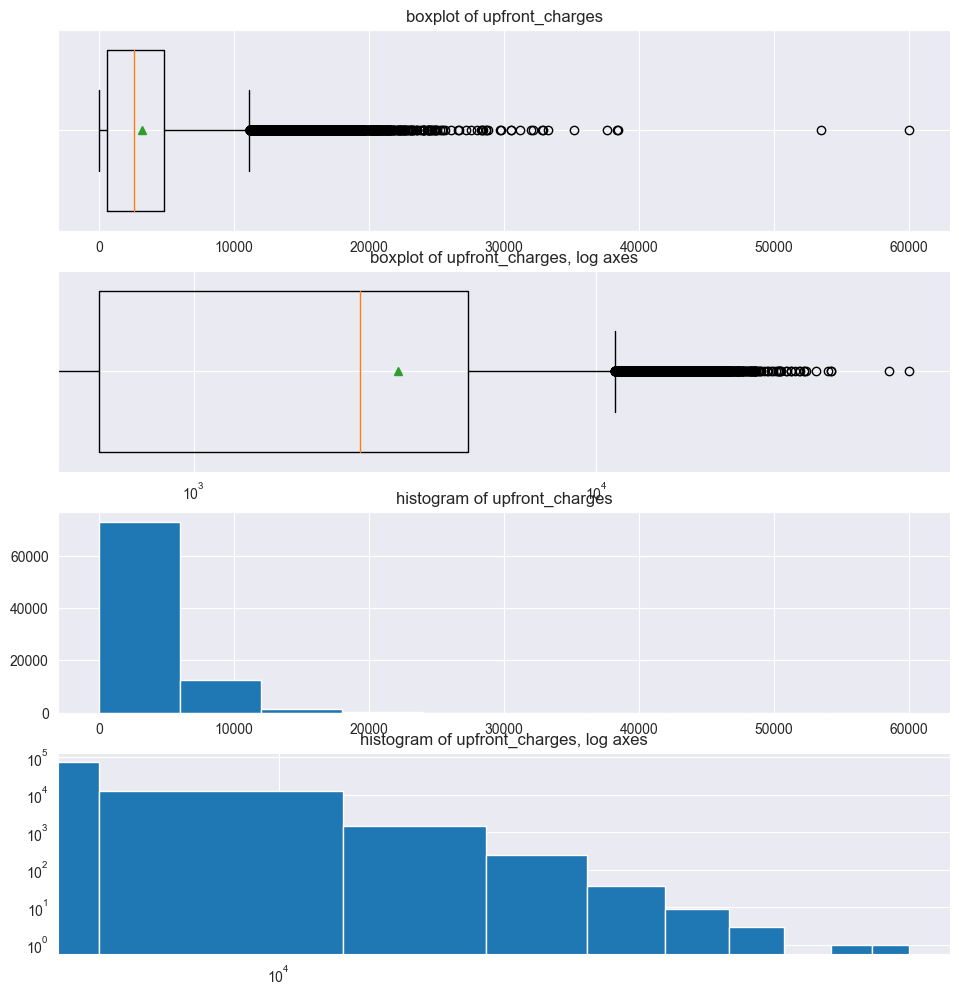

-------------------------------------------------------< term >------------------------------------------------------


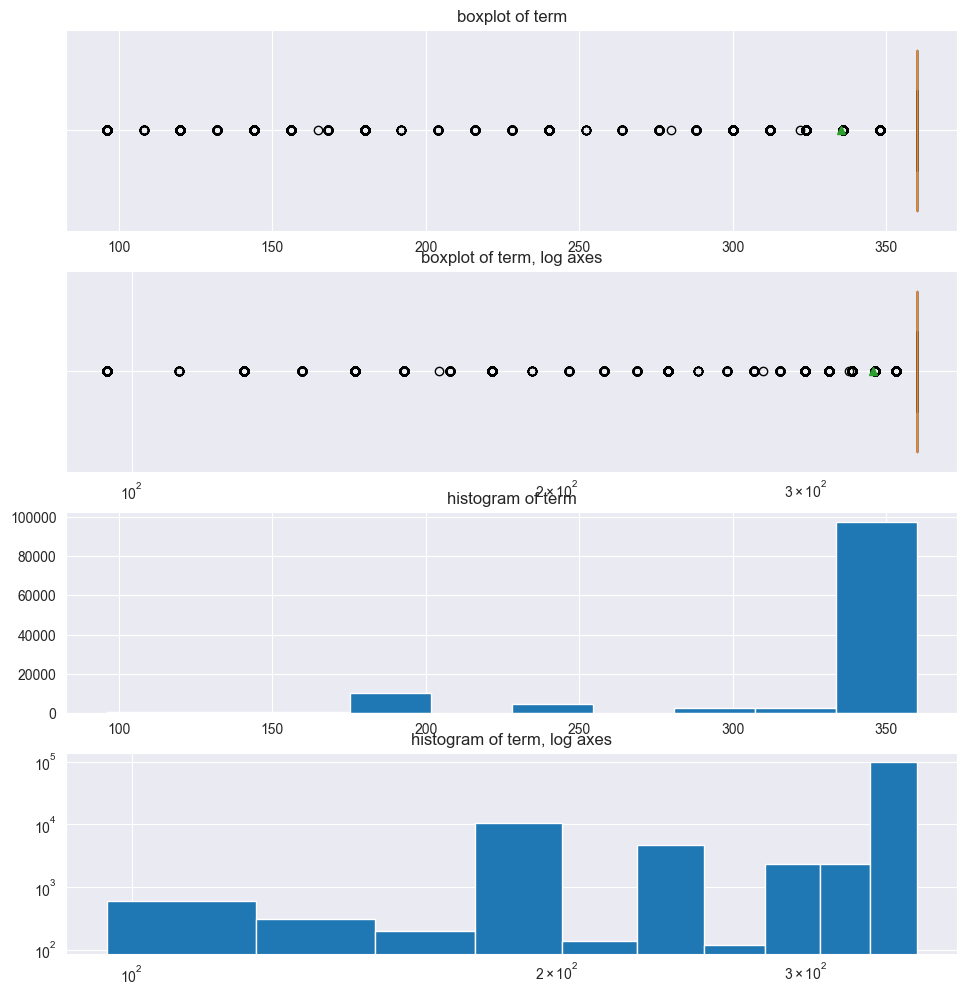

--------------------------------------------------< property_value >-------------------------------------------------


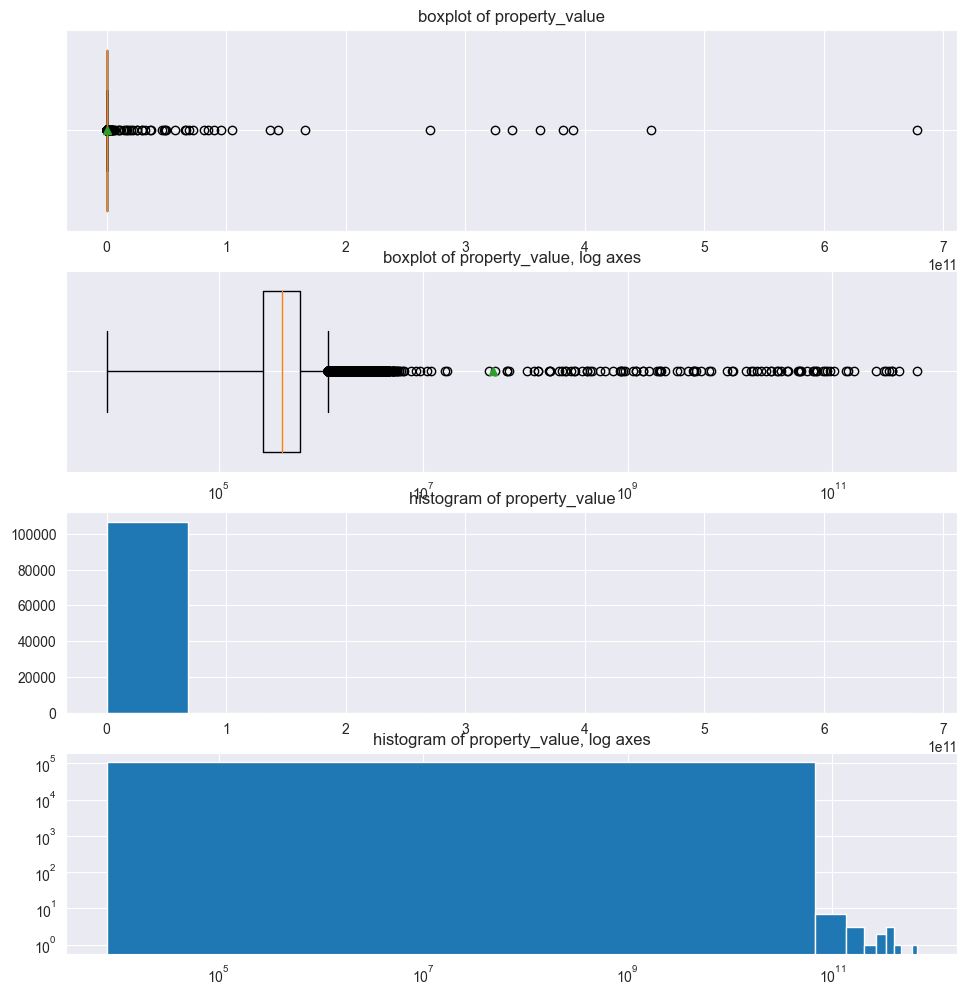

------------------------------------------------------< income >-----------------------------------------------------


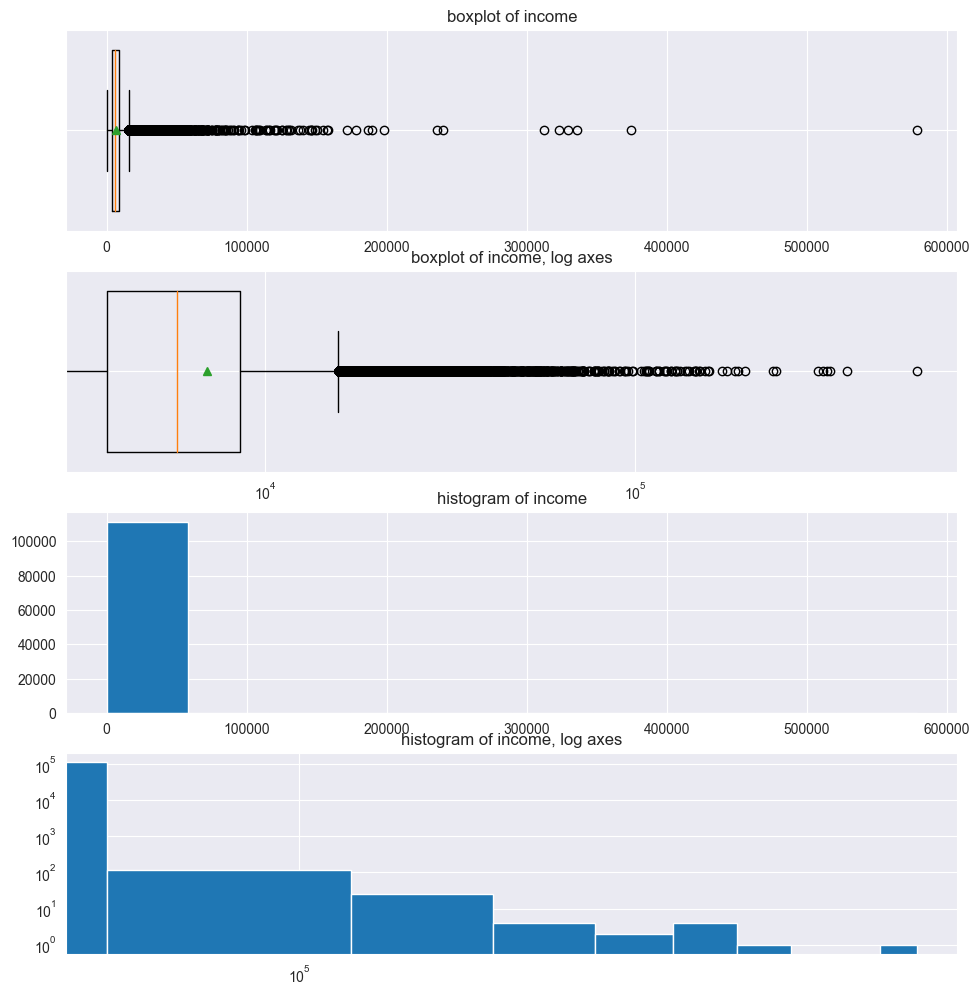

---------------------------------------------------< credit_score >--------------------------------------------------


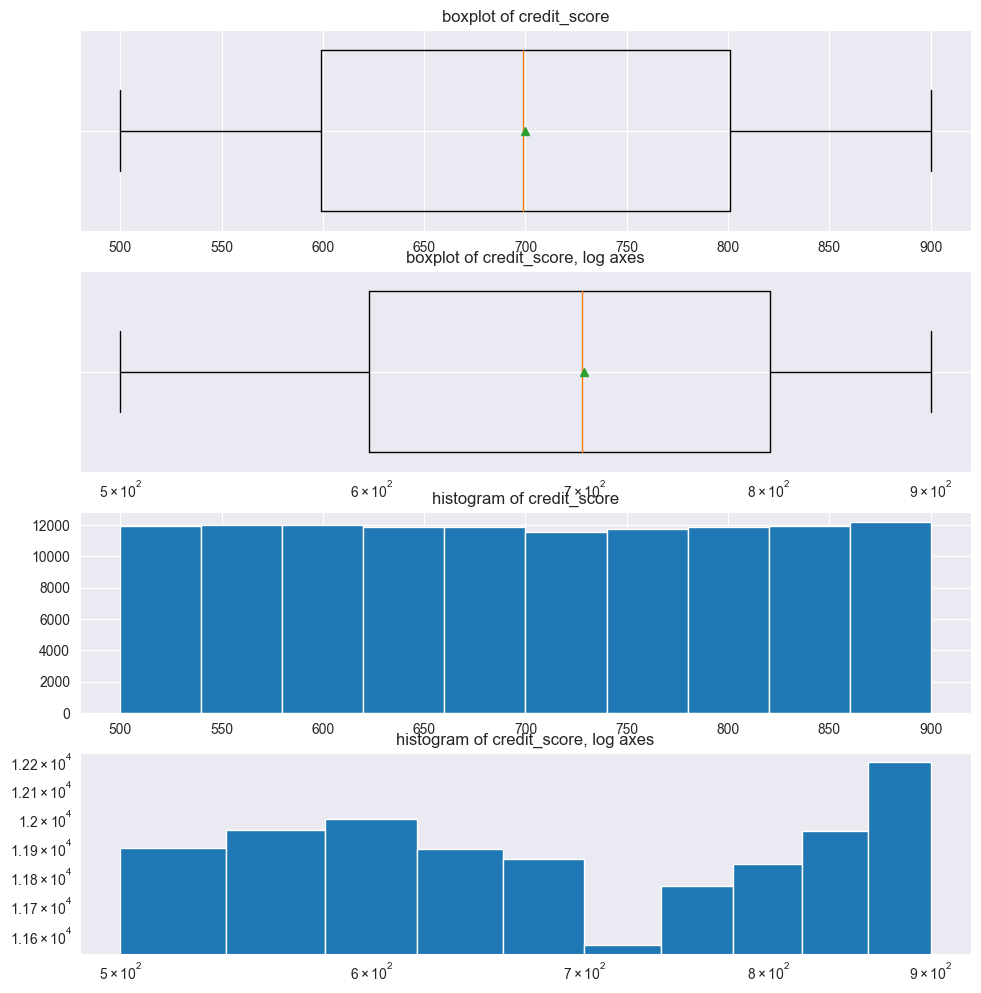

-------------------------------------------------------< ltv >-------------------------------------------------------


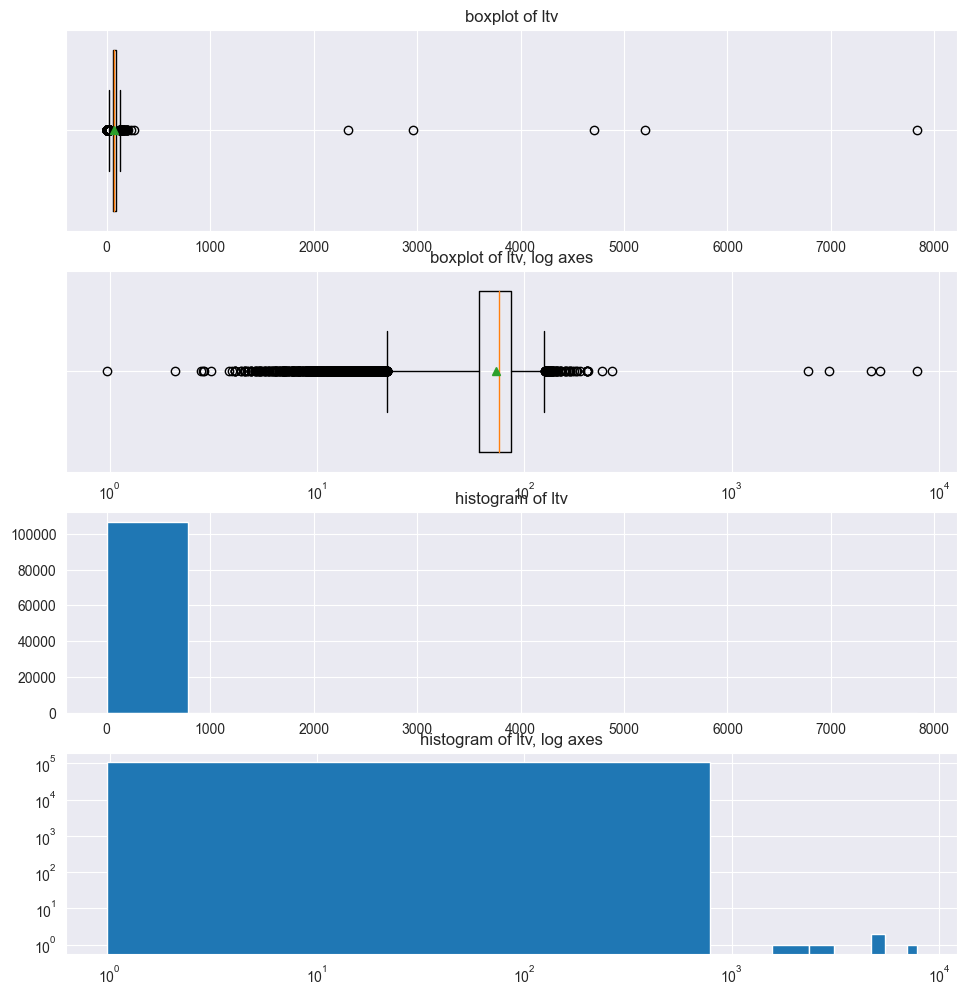

In [133]:
describe_numeric(X=X.select_dtypes(np.number))

В следующих столбцах имеются выбросы (крайнее значение 'сильно' превышает последний перцентиль):
- loan_amount
- interest_rate_spread
- upfront_charges
- term
- property_value
- income
- ltv

### Missing values detection

Есть ли пропущенные данные?

В следующих столбцах имеются отсутствующие значения:
- loan_limit
- approv_in_adv
- loan_purpose
- rate_of_interest
- interest_rate_spread
- upfront_charges
- term
- neg_ammortization
- property_value
- income
- age
- submission_of_application
- ltv

Отметим, что дополнительные пропуки могут появиться в колонке loan_amount после удаления экстримальных значений

Сразу удалим 0 в колонке income и обозначим его пропуском.

In [134]:
X.loc[X['income'] == 0, ['income']] = np.nan

---

<div class="alert alert-info">
  <h1><center>Preprocessing (3 балла)</center></h1></div>

# <center>Numerical features</center>

### Deal with extreme values

Напишите / используйте функции / трансформеры, которые будут "исправлять" экстримальные значения (какой способ лучше подходит? почему?)

Удалять экстримальные значения будем с помощью межквартильного расстояния. С другими не сильно и знаком...

In [135]:
for col_name, _ in X[['loan_amount',
                      'interest_rate_spread',
                      'upfront_charges',
                      'term',
                      'property_value',
                      'income',
                      'ltv']].items():
    Q1 = X[col_name].dropna().quantile(.25)
    Q3 = X[col_name].dropna().quantile(.75)
    IQR = Q3 - Q1

    X[col_name] = X[col_name].where(((X[col_name] >= Q1 - 1.5 * IQR)&(X[col_name] <= Q3 + 1.5 * IQR)))

### Deal with missing values

Напишите/используйте функции/трансформеры для заполнения пропущенных значений. Какова логика? Напишите краткое пояснение, почему Вы выбрали тот или иной подход

Для числовых признаков применим один из двух трансформеров. На медианное значение будем менять те фичи, где пропусков мало. На "соседнее" значение будем менять те фичи, где пропусков много. Кстати о пропусках... Инфа о них лежит в файле info_after_drop.txt.

In [136]:
with open('info/info_after_drop.txt', 'w') as f:
    for col_name, col_values in X.select_dtypes(np.number).items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

Для колонок с менее чем 20 % пропусков применим заполение средним. В другом случае попробуем сделать похожим на соседей. Также выбросим колонку со сроком кредитования. Почти все и так берут на год...

In [137]:
X.drop('term', axis=1, inplace=True)

In [138]:
median_imputer = SimpleImputer(strategy='median')
knn_imputer = KNNImputer(n_neighbors=5)

In [139]:
X[['loan_amount',
   'property_value',
   'income',
   'ltv']] = median_imputer.fit_transform(X[['loan_amount',
                                             'property_value',
                                             'income',
                                             'ltv']])
X[['rate_of_interest',
   'interest_rate_spread',
   'upfront_charges']] = knn_imputer.fit_transform(X[['rate_of_interest',
                                                      'interest_rate_spread',
                                                      'upfront_charges']])

Для оставшихся категориальных фич сделаем заполнение с помощью самого частого знечения.

In [140]:
freq_imputer = SimpleImputer(strategy='most_frequent')

In [141]:
X[['loan_limit',
   'approv_in_adv',
   'loan_purpose',
   'neg_ammortization',
   'age',
   'submission_of_application']] = freq_imputer.fit_transform(X[['loan_limit',
                                                                 'approv_in_adv',
                                                                 'loan_purpose',
                                                                 'neg_ammortization',
                                                                 'age',
                                                                 'submission_of_application']])

Итоговый обзор после удаления пропусковых и заполнения отсутсвующих значений:

In [142]:
X.head(2)

,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,secured_by,total_units,income,credit_type,credit_score,co_applicant_credit_type,age,submission_of_application,ltv,region,security_type
0,cf,Joint,nopre,type1,p4,l1,nopc,nob/c,216500.0,3.990,0.8696,1785.38,not_neg,not_int,not_lpsm,308000.0,sb,pr,home,1U,7380.0,EXP,512,EXP,65-74,to_inst,70.292208,North,direct
1,cf,Joint,nopre,type1,p1,l1,nopc,nob/c,606500.0,3.875,0.2662,3279.06,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,8580.0,EXP,588,EXP,35-44,not_inst,80.013193,North,direct


In [143]:
with open('info/info_аfter_fill_na.txt', 'w') as f:
    for col_name, col_values in X.items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

---

# <center>Categorical Features</center>

Какие признаки и как Вы будете кодировать?

### Encode nominal featuers

К номинальным фичам я отнесу:
- loan_limit
- gender
- approv_in_adv
- loan_type
- loan_purpose
- credit_worthiness
- open_credit
- business_or_commercial
- neg_ammortization
- interest_only
- lump_sum_payment
- construction_type
- occupancy_type
- secured_by
- credit_type
- co_applicant_credit_type
- submission_of_application
- region
- security_type

Номинальные фичи можно кодировать OneHotEncoder

In [144]:
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform="pandas")

In [145]:
encode_df = one_hot.fit_transform(X[['loan_limit',
                                     'gender',
                                     'approv_in_adv',
                                     'loan_type',
                                     'loan_purpose',
                                     'credit_worthiness',
                                     'open_credit',
                                     'business_or_commercial',
                                     'neg_ammortization',
                                     'interest_only',
                                     'lump_sum_payment',
                                     'construction_type',
                                     'occupancy_type',
                                     'secured_by',
                                     'credit_type',
                                     'co_applicant_credit_type',
                                     'submission_of_application',
                                     'region',
                                     'security_type']])

In [146]:
X = X.join(encode_df)
X.drop(['loan_limit',
        'gender',
        'approv_in_adv',
        'loan_type',
        'loan_purpose',
        'credit_worthiness',
        'open_credit',
        'business_or_commercial',
        'neg_ammortization',
        'interest_only',
        'lump_sum_payment',
        'construction_type',
        'occupancy_type',
        'secured_by',
        'credit_type',
        'co_applicant_credit_type',
        'submission_of_application',
        'region',
        'security_type'],
        axis=1,
        inplace=True)

### Encode ordinal features

К порядковым фичам я отнесу:
- total_units
- age

In [147]:
total_units_enc = OrdinalEncoder(categories=[['1U', '2U', '3U', '4U'],
                                             ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']],
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1)

In [148]:
X[['total_units', 'age']] = total_units_enc.fit_transform(X[['total_units', 'age']])

In [149]:
X.shape

(118936, 58)

In [150]:
pd.set_option("display.max_columns", X.shape[-1])

In [151]:
X.head(2)

,loan_amount,rate_of_interest,interest_rate_spread,upfront_charges,property_value,total_units,income,credit_score,age,ltv,loan_limit_cf,loan_limit_ncf,gender_Female,gender_Joint,gender_Male,gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,credit_worthiness_l1,credit_worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,neg_ammortization_neg_amm,neg_ammortization_not_neg,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,secured_by_home,secured_by_land,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co_applicant_credit_type_CIB,co_applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,region_North,region_North-East,region_central,region_south,security_type_Indriect,security_type_direct
0,216500.0,3.990,0.8696,1785.38,308000.0,0.0,7380.0,512,5.0,70.292208,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,606500.0,3.875,0.2662,3279.06,758000.0,0.0,8580.0,588,2.0,80.013193,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Сделаем последний обзор (без пайплайна). Смотреть info_final_without_pipe.txt

In [152]:
with open('info/info_final_without_pipe.txt', 'w') as f:
    for col_name, col_values in X.items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

In [153]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118936 entries, 0 to 118935
Data columns (total 58 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   loan_amount                         118936 non-null  float64
 1   rate_of_interest                    118936 non-null  float64
 2   interest_rate_spread                118936 non-null  float64
 3   upfront_charges                     118936 non-null  float64
 4   property_value                      118936 non-null  float64
 5   total_units                         118936 non-null  float64
 6   income                              118936 non-null  float64
 7   credit_score                        118936 non-null  int64  
 8   age                                 118936 non-null  float64
 9   ltv                                 118936 non-null  float64
 10  loan_limit_cf                       118936 non-null  float64
 11  loan_limit_ncf            

---

<div class="alert alert-info">
  <h1><center>Pipeline (3 балла)</center></h1></div>

Соберите pipeline, который будет реализовывать все предыдущие трансформации

Немного подсмотрел и решил также перепройти все шаги заново и сделать весь препроцессинг на одном пайплане.

In [154]:
df = pd.read_csv("data/train.csv", low_memory=False)
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(r'-', r'_', regex=True)

In [155]:
X = df.drop(columns=['status', 'year', 'term', 'id'])
y = df['status']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Для преобразования ноль в np.nan напишем такой трансформер:

In [157]:
class ZeroToNaNTransformer(CustomTransformer):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[X_transformed == 0] = np.nan
        return X_transformed

Сначала отловим ошибки:

In [158]:
mistake_transformer = ColumnTransformer(transformers=[('income',
                                                       ZeroToNaNTransformer(),
                                                       ['income']),
                                                      ('credit_score',
                                                       RegexTransformer(replace={'_':''},
                                                                        get_first=False,
                                                                        target_dtype=float),
                                                       ['credit_score'])],
                                        remainder='passthrough',
                                        verbose_feature_names_out=False)
mistake_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('income', ZeroToNaNTransformer(), ['income']),
                                ('credit_score',
                                 RegexTransformer(get_first=False,
                                                  replace={'_': ''},
                                                  target_dtype=<class 'float'>),
                                 ['credit_score'])],
                  verbose_feature_names_out=False)

Экстремальные значения:

In [159]:
outlier_transformer = ColumnTransformer(transformers=[('IQR_outliers',
                                                       IQROutlierDetector(),
                                                       ['loan_amount',
                                                        'interest_rate_spread',
                                                        'upfront_charges',
                                                        'property_value',
                                                        'income',
                                                        'ltv'])],
                                        remainder='passthrough',
                                        verbose_feature_names_out=False)
outlier_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('IQR_outliers', IQROutlierDetector(),
                                 ['loan_amount', 'interest_rate_spread',
                                  'upfront_charges', 'property_value', 'income',
                                  'ltv'])],
                  verbose_feature_names_out=False)

Заполнение числовых пропусков:

In [160]:
numeric_imputer_transformer = ColumnTransformer(transformers=[('knn_imputer',
                                                               KNNImputer(),
                                                               ['rate_of_interest',
                                                                'interest_rate_spread',
                                                                'upfront_charges']), 
                                                              ('median_imputer',
                                                               SimpleImputer(strategy="median"),
                                                               ['loan_amount',
                                                                'property_value',
                                                                'income',
                                                                'ltv'])],
                                                remainder='passthrough',
                                                verbose_feature_names_out=False)
numeric_imputer_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('knn_imputer', KNNImputer(),
                                 ['rate_of_interest', 'interest_rate_spread',
                                  'upfront_charges']),
                                ('median_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['loan_amount', 'property_value', 'income',
                                  'ltv'])],
                  verbose_feature_names_out=False)

Заполнение категориальных фич:

In [161]:
categorical_imputer_transformer = ColumnTransformer(transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy="most_frequent"),
                                                                   ['loan_limit',
                                                                    'approv_in_adv',
                                                                    'loan_purpose',
                                                                    'neg_ammortization',
                                                                    'age',
                                                                    'submission_of_application'])],
                                                    remainder="passthrough", verbose_feature_names_out=False)
categorical_imputer_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['loan_limit', 'approv_in_adv', 'loan_purpose',
                                  'neg_ammortization', 'age',
                                  'submission_of_application'])],
                  verbose_feature_names_out=False)

Кодировка категориалььных фичей.

In [162]:
encode_nominal_transformer = ColumnTransformer(transformers=[('onehotencoder',
                                                              OneHotEncoder(sparse_output=False,
                                                                            handle_unknown='ignore'),
                                                              ['loan_limit',
                                                               'gender',
                                                               'approv_in_adv',
                                                               'loan_type',
                                                               'loan_purpose',
                                                               'credit_worthiness',
                                                               'open_credit',
                                                               'business_or_commercial',
                                                               'neg_ammortization',
                                                               'interest_only',
                                                               'lump_sum_payment',
                                                               'construction_type',
                                                               'occupancy_type',
                                                               'secured_by',
                                                               'credit_type',
                                                               'co_applicant_credit_type',
                                                               'submission_of_application',
                                                               'region',
                                                               'security_type']),
                                                             ('ordinalencoder',
                                                              OrdinalEncoder(categories=[['1U', '2U', '3U', '4U'],
                                                                                         ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']],
                                                                             handle_unknown='use_encoded_value',
                                                                             unknown_value=-1),
                                                              ['total_units', 'age'])],                      
                                               remainder='passthrough',
                                               verbose_feature_names_out=False)

encode_nominal_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['loan_limit', 'gender', 'approv_in_adv',
                                  'loan_type', 'loan_purpose',
                                  'credit_worthiness', 'open_credit',
                                  'business_or_commercial', 'neg_ammortization',
                                  'interest_only', 'lump_sum_payment',
                                  'construction_type', 'occupancy_type',
                                  'secured_by', 'credit_type',
                                  'co_applicant_credit_type',
                                  'submission_of_application', 'region',
                                  'security_type']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['1U', '2U', '3U',
                                                             '4U'],
                                                            ['<25', '25-34',
                                                             '35-44', '45-54',
                                                             '55-64', '65-74',
                                                             '>74']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['total_units', 'age'])],
                  verbose_feature_names_out=False)

Обработка числовых значений состоит в поиске экстремальных значений и заполнении пропусков:

In [163]:
numeric_pipe = Pipeline([
    ("outlier_handler", outlier_transformer),
    ("num_imputer", numeric_imputer_transformer)])

numeric_pipe.set_output(transform="pandas")

Pipeline(steps=[('outlier_handler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('IQR_outliers',
                                                  IQROutlierDetector(),
                                                  ['loan_amount',
                                                   'interest_rate_spread',
                                                   'upfront_charges',
                                                   'property_value', 'income',
                                                   'ltv'])],
                                   verbose_feature_names_out=False)),
                ('num_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knn_imputer', KNNImputer(),
                                                  ['rate_of_interest',
                                                   'interest_rate_spread',
                                                   'upfront_charges']),
                                                 ('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['loan_amount',
                                                   'property_value', 'income',
                                                   'ltv'])],
                                   verbose_feature_names_out=False))])

Обработка категориалных значений состоит в заполнении пропусков и кодировке в чисовые значения:

In [164]:
category_pipe = Pipeline([
    ("cat_imputer", categorical_imputer_transformer),
    ("nominal_encoder", encode_nominal_transformer)])

category_pipe.set_output(transform="pandas")

Pipeline(steps=[('cat_imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['loan_limit',
                                                   'approv_in_adv',
                                                   'loan_purpose',
                                                   'neg_ammortization', 'age',
                                                   'submission_of_application'])],
                                   verbose_feature_names_out=False)),
                ('nominal_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transforme...
                                                   'occupancy_type',
                                                   'secured_by', 'credit_type',
                                                   'co_applicant_credit_type',
                                                   'submission_of_application',
                                                   'region', 'security_type']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['1U',
                                                                              '2U',
                                                                              '3U',
                                                                              '4U'],
                                                                             ['<25',
                                                                              '25-34',
                                                                              '35-44',
                                                                              '45-54',
                                                                              '55-64',
                                                                              '65-74',
                                                                              '>74']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['total_units', 'age'])],
                                   verbose_feature_names_out=False))])

Вся обработка значений включает оба этих пайпа:

In [165]:
processing_transformer = ColumnTransformer(transformers=[("categorical", category_pipe, make_column_selector(dtype_include=object)), 
                                                        ("numeric", numeric_pipe, make_column_selector(dtype_include=np.number))],
                                                        remainder="drop", verbose_feature_names_out=False)
processing_transformer.set_output(transform="pandas")

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('cat_imputer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('mode_imputer',
                                                                                   SimpleImputer(strategy='most_frequent'),
                                                                                   ['loan_limit',
                                                                                    'approv_in_adv',
                                                                                    'loan_purpose',
                                                                                    'neg_ammortization',
                                                                                    'age',
                                                                                    'submission_of_application'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('nominal_encoder',
                                                  Colum...
                                                                    transformers=[('knn_imputer',
                                                                                   KNNImputer(),
                                                                                   ['rate_of_interest',
                                                                                    'interest_rate_spread',
                                                                                    'upfront_charges']),
                                                                                  ('median_imputer',
                                                                                   SimpleImputer(strategy='median'),
                                                                                   ['loan_amount',
                                                                                    'property_value',
                                                                                    'income',
                                                                                    'ltv'])],
                                                                    verbose_feature_names_out=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF2160A740>)],
                  verbose_feature_names_out=False)

Финальный пайплайн включает перед этим поиск ошибок:

In [166]:
pipe = Pipeline([
    ("mistakes_remover_and_dtype_converter", mistake_transformer),
    ("data_processing", processing_transformer)])

pipe.set_output(transform="pandas")

Pipeline(steps=[('mistakes_remover_and_dtype_converter',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('income',
                                                  ZeroToNaNTransformer(),
                                                  ['income']),
                                                 ('credit_score',
                                                  RegexTransformer(get_first=False,
                                                                   replace={'_': ''},
                                                                   target_dtype=<class 'float'>),
                                                  ['credit_score'])],
                                   verbose_feature_names_out=False)),
                ('data_processing',
                 ColumnTransformer(transfor...
                                                                                     transformers=[('knn_imputer',
                                                                                                    KNNImputer(),
                                                                                                    ['rate_of_interest',
                                                                                                     'interest_rate_spread',
                                                                                                     'upfront_charges']),
                                                                                                   ('median_imputer',
                                                                                                    SimpleImputer(strategy='median'),
                                                                                                    ['loan_amount',
                                                                                                     'property_value',
                                                                                                     'income',
                                                                                                     'ltv'])],
                                                                                     verbose_feature_names_out=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF2160A740>)],
                                   verbose_feature_names_out=False))])

Обучим пайплайн:

In [167]:
X_train = pipe.fit_transform(X_train)

Запиклим обученный пайплайн (и убьем в памяти для имитации переноса): 

In [168]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

pipe = None

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

pipe

Pipeline(steps=[('mistakes_remover_and_dtype_converter',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('income',
                                                  ZeroToNaNTransformer(),
                                                  ['income']),
                                                 ('credit_score',
                                                  RegexTransformer(get_first=False,
                                                                   replace={'_': ''},
                                                                   target_dtype=<class 'float'>),
                                                  ['credit_score'])],
                                   verbose_feature_names_out=False)),
                ('data_processing',
                 ColumnTransformer(transfor...
                                                                                     transformers=[('knn_imputer',
                                                                                                    KNNImputer(),
                                                                                                    ['rate_of_interest',
                                                                                                     'interest_rate_spread',
                                                                                                     'upfront_charges']),
                                                                                                   ('median_imputer',
                                                                                                    SimpleImputer(strategy='median'),
                                                                                                    ['loan_amount',
                                                                                                     'property_value',
                                                                                                     'income',
                                                                                                     'ltv'])],
                                                                                     verbose_feature_names_out=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF216098A0>)],
                                   verbose_feature_names_out=False))])

Применим пайплайн для обработки тестовой выборки:

In [169]:
X_test = pipe.transform(X_test)

Запишем для большего удобства датафреймы в csv-файлы:

In [175]:
df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

In [176]:
df_train.to_csv('data/proc_train.csv', index=False)
df_test.to_csv('data/proc_test.csv', index=False)

Финальный осмотр:

In [177]:
with open('info/info_train_final.txt', 'w') as f:
    for col_name, col_values in df_train.items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

In [178]:
with open('info/info_test_final.txt', 'w') as f:
    for col_name, col_values in df_test.items():
        f.write(f"< {col_name} >".center(100, "-") + "\n")
        f.write(f"Data type: {col_values.dtype}\n")
        f.write(f"Is unique: {col_values.is_unique}\n")
        f.write(f"% of Nones: {col_values.isna().mean()}\n")

        if col_values.dtype != 'O':
            f.write(f"Statistics:\n{col_values.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])}\n")
        else:
            f.write(f"Unique values:\n{col_values.value_counts()}\n")

---

<div class="alert alert-info">
  <h1><center>Model (2 балла)</center></h1></div>

Выберите любую из пройденных моделей и примените её к обработанному датасету

Оцените модель при помощи изученных метрик

Что можно сделать, чтобы оптимизировать полученную модель?

---

# <center>Удачи!</center>